In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
fashion_mnist=tf.keras.datasets.fashion_mnist
(x_train,y_train_sparse),(x_test,y_test_sparse)=fashion_mnist.load_data()
print(x_train.shape,x_test.shape)
from tensorflow.keras.utils import to_categorical, plot_model
y_train=to_categorical(y_train_sparse)
y_test=to_categorical(y_test_sparse)
print(y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(10000, 10)


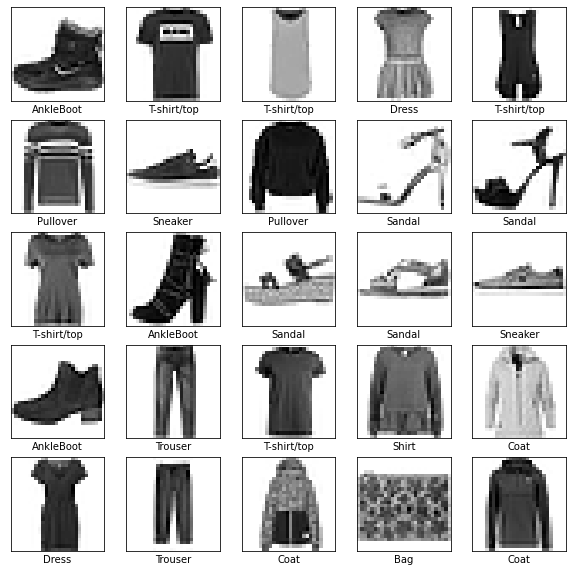

In [2]:
x_train=x_train/255.0
x_test=x_test/255.0

class_names=['T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','AnkleBoot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_sparse[i]])
plt.show()

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Activation,LeakyReLU,PReLU,BatchNormalization
model=Sequential()
model.add(Flatten(input_shape=[28,28]))
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization(momentum=0.9))
model.add(Dense(128,activation='selu',kernel_initializer='lecun_normal'))
model.add(BatchNormalization(center=False, scale=False))
model.add(Dense(10,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 10)                1

# 맞춤형 딥러닝 설계

## (1) 맞춤형 loss 함수

In [4]:
#@tf.function
def sse_linear_loss(y_true,y_pred):
    error=tf.abs(y_true-y_pred)
    is_error=error<0.3
    error_1=tf.reduce_sum(tf.square(error))
    error_2=tf.reduce_sum(error)
    return tf.where(is_error, error_1,error_2)   

In [5]:
model.compile(loss=sse_linear_loss, optimizer='nadam',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 13s 7ms/step - loss: 8.4953 - accuracy: 0.8246 - val_loss: 7.4072 - val_accuracy: 0.8444
Epoch 2/10
1500/1500 [==============================] - 12s 8ms/step - loss: 6.6917 - accuracy: 0.8616 - val_loss: 6.4602 - val_accuracy: 0.8658
Epoch 3/10
1500/1500 [==============================] - 12s 8ms/step - loss: 6.0513 - accuracy: 0.8751 - val_loss: 5.9877 - val_accuracy: 0.8767
Epoch 4/10
1500/1500 [==============================] - 13s 9ms/step - loss: 5.6068 - accuracy: 0.8842 - val_loss: 6.0064 - val_accuracy: 0.8744
Epoch 5/10
1500/1500 [==============================] - 12s 8ms/step - loss: 5.3066 - accuracy: 0.8899 - val_loss: 5.7683 - val_accuracy: 0.8784
Epoch 6/10
1500/1500 [==============================] - 12s 8ms/step - loss: 5.0016 - accuracy: 0.8982 - val_loss: 5.5029 - val_accuracy: 0.8870
Epoch 7/10
1500/1500 [==============================] - 12s 8ms/step - loss: 4.8178 - accuracy: 0.9014 - val_loss: 5.4557 - val_ac

In [6]:
class SseLinearLoss(tf.keras.losses.Loss):
    def __init__(self,threshold=0.3,**kwargs):
        self.threshold=threshold
        super().__init__(**kwargs)
    def call(self,y_true,y_pred):
        error=tf.abs(y_true-y_pred)
        is_error=error<self.threshold
        error_1=tf.reduce_sum(tf.square(error))
        error_2=tf.reduce_sum(error)
        return tf.where(is_error, error_1,error_2)
    def get_config(self):
        base_config=super().get_config()
        return {**base_config, 'threshold':self.threshold}

In [7]:
model.compile(loss=SseLinearLoss(0.4), optimizer='nadam',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 10s 6ms/step - loss: 4.0269 - accuracy: 0.9193 - val_loss: 5.3011 - val_accuracy: 0.8895
Epoch 2/10
1500/1500 [==============================] - 8s 5ms/step - loss: 3.9678 - accuracy: 0.9177 - val_loss: 5.4896 - val_accuracy: 0.8870
Epoch 3/10
1500/1500 [==============================] - 8s 6ms/step - loss: 3.8802 - accuracy: 0.9232 - val_loss: 5.5550 - val_accuracy: 0.8831
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 3.6302 - accuracy: 0.9265 - val_loss: 5.2005 - val_accuracy: 0.8930
Epoch 5/10
1500/1500 [==============================] - 9s 6ms/step - loss: 3.5871 - accuracy: 0.9277 - val_loss: 5.3772 - val_accuracy: 0.8892
Epoch 6/10
1500/1500 [==============================] - 8s 6ms/step - loss: 3.4942 - accuracy: 0.9302 - val_loss: 5.4753 - val_accuracy: 0.8871
Epoch 7/10
1500/1500 [==============================] - 9s 6ms/step - loss: 3.2478 - accuracy: 0.9344 - val_loss: 5.5225 - val_accuracy

## boston_housing

In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
(x_train,y_train),(x_test,y_test)=boston_housing.load_data()
print(x_train.dtype,y_train.dtype)
print(x_train.shape,y_train.shape)
print(x_test.shape)

float64 float64
(404, 13) (404,)
(102, 13)


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as k
# 회귀임.
input_A=Input(shape=[13])
h1=Dense(32,activation='elu',kernel_initializer='he_normal')(input_A)
h2=Dense(32,activation='elu',kernel_initializer='he_normal')(h1)
h3=Dense(32,activation='elu',kernel_initializer='he_normal')(h2)
recon=Dense(13,activation='elu',kernel_initializer='he_normal')(h3) # input shape와 똑같이 만들어줌, input variable을 살려내겠다.
out1=Dense(1)(h3)
model=Model(input_A,out1)
recon_loss=tf.reduce_mean(tf.square(input_A-recon)) # mse
model.add_loss(0.05*recon_loss) # recon_loss 0.05 정도의 중요도로 주손실함수에 추가
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 32)           448         ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 32)           1056        ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 32)           1056        ['dense_4[0][0]']                
                                                                                              

In [13]:
model.compile(loss='mse',optimizer='nadam')
history=model.fit(x_train,y_train,epochs=10, batch_size=32, validation_data=(x_test,y_test))

Epoch 1/10
13/13 [==============================] - 1s 16ms/step - loss: 2180.9691 - val_loss: 1380.3018
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 1240.8312 - val_loss: 986.2635
Epoch 3/10
13/13 [==============================] - 0s 4ms/step - loss: 887.7741 - val_loss: 673.0706
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 599.9198 - val_loss: 456.0323
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 416.7390 - val_loss: 388.5136
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 308.6765 - val_loss: 224.8198
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 221.7923 - val_loss: 199.9437
Epoch 8/10
13/13 [==============================] - 0s 5ms/step - loss: 192.2495 - val_loss: 266.1062
Epoch 9/10
13/13 [==============================] - 0s 5ms/step - loss: 184.7961 - val_loss: 154.6927
Epoch 10/10
13/13 [==============================] - 0s 4ms/step - loss: 170.2

In [9]:
class ReconReg(tf.keras.models.Model):
    def __init__(self,out_dim,**kwargs):
        super().__init__(**kwargs)
        self.hidden=[Dense(32,activation='elu',kernel_initializer='he_normal') for _ in range(3)]
        self.out=Dense(out_dim)
    def build(self,batch_input_shape):
        n_inputs=batch_input_shape[-1]
        self.recon=Dense(n_inputs)
        super(),build(batch_input_shape)
    def call(self,inputs):
        z=inputs
        for layer in self.hidden:
            z=layer(z)
        recon=self.recon(z)
        recon_loss=tf.reduce_mean(tf.square(recon-inputs))
        self.add_loss(0.05*recon_loss)
        return self.out(z)

In [10]:
class ReconReg(tf.keras.models.Model):
    def __init__(self,input_dim,out_dim,**kwargs):
        super().__init__(**kwargs)
        self.hidden=[Dense(32,activation='elu',kernel_initializer='he_normal') for _ in range(3)]
        self.out=Dense(out_dim)
        self.recon=Dense(input_dim)
   
    def call(self,inputs):
        z=inputs
        for layer in self.hidden:
            z=layer(z)
        recon=self.recon(z)
        recon_loss=tf.reduce_mean(tf.square(recon-inputs))
        self.add_loss(0.05*recon_loss)
        return self.out(z)

In [22]:
model=ReconReg(13,1)
model.compile( loss='mse',optimizer='nadam')
history=model.fit(x_train,y_train,epochs=10, batch_size=32, validation_data=(x_test,y_test))

Epoch 1/10
13/13 [==============================] - 1s 16ms/step - loss: 7093.9819 - val_loss: 2882.6655
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 2404.5696 - val_loss: 1904.1705
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 1658.1596 - val_loss: 1393.5576
Epoch 4/10
13/13 [==============================] - 0s 4ms/step - loss: 1186.5219 - val_loss: 994.9289
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 843.4670 - val_loss: 708.3458
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 574.3824 - val_loss: 442.3493
Epoch 7/10
13/13 [==============================] - 0s 4ms/step - loss: 397.3774 - val_loss: 399.3286
Epoch 8/10
13/13 [==============================] - 0s 4ms/step - loss: 323.4059 - val_loss: 231.6639
Epoch 9/10
13/13 [==============================] - 0s 5ms/step - loss: 250.4557 - val_loss: 209.9070
Epoch 10/10
13/13 [==============================] - 0s 5ms/step - loss: 2

In [19]:
model.summary()

Model: "recon_reg_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             multiple                  448       
_________________________________________________________________
dense_32 (Dense)             multiple                  1056      
_________________________________________________________________
dense_33 (Dense)             multiple                  1056      
_________________________________________________________________
dense_34 (Dense)             multiple                  33        
_________________________________________________________________
dense (Dense)                multiple                  429       
Total params: 3,022
Trainable params: 3,022
Non-trainable params: 0
_________________________________________________________________


## (2) 맞춤형 은닉층

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
fashion_mnist=tf.keras.datasets.fashion_mnist
(x_train,y_train_sparse),(x_test,y_test_sparse)=fashion_mnist.load_data()
print(x_train.shape,x_test.shape)
from tensorflow.keras.utils import to_categorical, plot_model
y_train=to_categorical(y_train_sparse)
y_test=to_categorical(y_test_sparse)
print(y_test.shape)
x_train=x_train/255.0
x_test=x_test/255.0

(60000, 28, 28) (10000, 28, 28)
(10000, 10)


In [12]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self,nlayers,n_nodes,**kwargs):
        super().__init__(**kwargs)
        self.hidden=[tf.keras.layers.Dense(n_nodes,activation='elu',kernel_initializer='he_normal') for _ in range(nlayers)]
    def call(self,inputs):
        z=inputs
        for layer in self.hidden:
            z=layer(z)
        return tf.concat([inputs,z], axis=-1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               200960    
                                                                 
 residual_block (ResidualBlo  (None, 512)              131584    
 ck)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 residual_block_1 (ResidualB  (None, 256)             

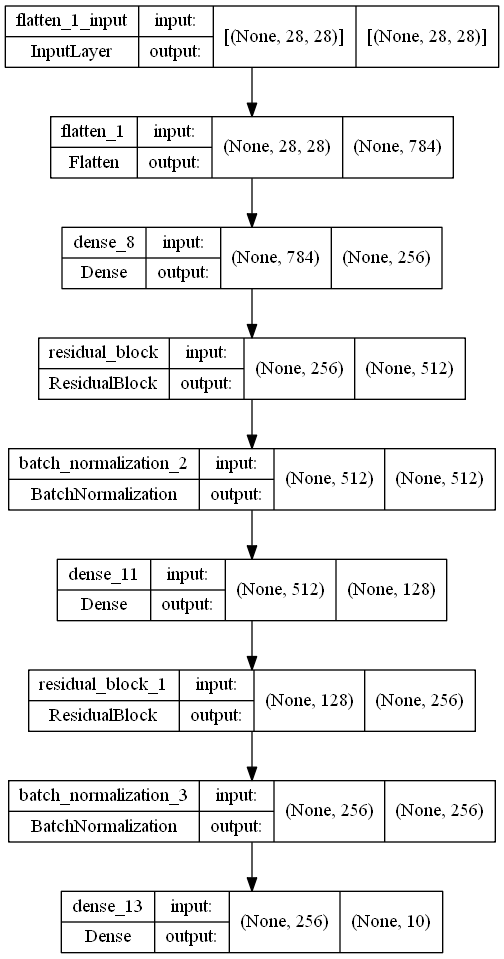

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Activation,BatchNormalization
model=Sequential()
model.add(Flatten(input_shape=[28,28]))
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(ResidualBlock(2,256))
model.add(BatchNormalization(momentum=0.9))
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(ResidualBlock(1,128))
model.add(BatchNormalization(center=False, scale=False))
model.add(Dense(10,activation='softmax'))
model.summary()
plot_model(model,show_shapes=True)

In [26]:
model.compile(loss='categorical_crossentropy',optimizer='nadam', metrics=['accuracy'])
results=model.fit(x_train,y_train, batch_size=32, epochs=10,validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 16s 8ms/step - loss: 0.5606 - accuracy: 0.8018 - val_loss: 0.3715 - val_accuracy: 0.8650
Epoch 2/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3670 - accuracy: 0.8646 - val_loss: 0.3923 - val_accuracy: 0.8522
Epoch 3/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3220 - accuracy: 0.8815 - val_loss: 0.3297 - val_accuracy: 0.8785
Epoch 4/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2968 - accuracy: 0.8894 - val_loss: 0.3503 - val_accuracy: 0.8768
Epoch 5/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2806 - accuracy: 0.8949 - val_loss: 0.3312 - val_accuracy: 0.8770
Epoch 6/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2611 - accuracy: 0.9032 - val_loss: 0.3344 - val_accuracy: 0.8817
Epoch 7/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2494 - accuracy: 0.9046 - val_loss: 0.3261 - val_ac

In [14]:
class AddDense(tf.keras.layers.Layer):
    def __init__(self,nodes,activation=None,**kwargs):
        super().__init__(**kwargs)
        self.nodes=nodes
        self.activation=tf.keras.activations.get(activation)
    def build(self, batch_input_shape):
        self.W=self.add_weight(shape=[batch_input_shape[-1],self.nodes])
        self.b=self.add_weight(shape=[self.nodes,])
        super().build(batch_input_shape)
    def call(self,x):
        return self.activation(x@self.W+self.b)
    def compute_output_shape(self,batch_input_shape):
        return tf.TensorShape.as_list([batch_input_shape[:-1],self.nodes])
    def get_config(self):
        base_config=super.get_config()
        return {**base_config, 'nodes':self.nodes,'activation':tf.keras.activations(self.activation)}

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Activation,LeakyReLU,PReLU,BatchNormalization
model=Sequential()
model.add(Flatten(input_shape=[28,28]))
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(AddDense(256,activation='relu'))
model.add(BatchNormalization(momentum=0.9))
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(AddDense(64,activation='relu'))
model.add(BatchNormalization(center=False, scale=False))
model.add(Dense(10,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               200960    
                                                                 
 add_dense (AddDense)        (None, 256)               65792     
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 add_dense_1 (AddDense)      (None, 64)                8256      
                                                      

In [29]:
model.compile(loss='categorical_crossentropy',optimizer='nadam', metrics=['accuracy'])
results=model.fit(x_train,y_train, batch_size=32, epochs=10,validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 13s 7ms/step - loss: 0.5888 - accuracy: 0.7971 - val_loss: 0.4469 - val_accuracy: 0.8305
Epoch 2/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.3947 - accuracy: 0.8584 - val_loss: 0.4237 - val_accuracy: 0.8395
Epoch 3/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.3555 - accuracy: 0.8715 - val_loss: 0.3596 - val_accuracy: 0.8703
Epoch 4/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.3287 - accuracy: 0.8791 - val_loss: 0.3351 - val_accuracy: 0.8763
Epoch 5/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.3157 - accuracy: 0.8826 - val_loss: 0.3246 - val_accuracy: 0.8813
Epoch 6/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.2953 - accuracy: 0.8927 - val_loss: 0.3626 - val_accuracy: 0.8743
Epoch 7/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.2883 - accuracy: 0.8948 - val_loss: 0.3202 - val_ac